# Gestion des risques multiples
---
- ABOULA EDANG Jean Grivo
- DEBA WANDJI Franck Delma
- KOUGOUM MOKO MANI Marilene
---

# Contexte


---
L'objectif de la présent étude est d'évaluer, au moyen d'une CVAR à 99%, le risque de crédit sur un portefeuille composé de deux créances, issues du secteur bancaire, de même notionnel 1000 EUR et de même maturité 4 ans.

La première est une obligation BNP senior de taux de recouvrement de moyenne 60% et de volatilité 15%, et la seconde est une obligation Société Générale junior (ou subordonnée) de taux de recouvrement de moyenne 30% et de volatilité 25%. On suppose qu’il n’y a pas de dépendance entre les taux de recouvrement.

La perte de crédit attendue sur ce portefeuille peut s'écrire sous la forme mathématique suivante
$L= EAD_{BNP} (1 - R_{BNP}) \mathbf{1}_{\tau_{BNP} \leq 4} + EAD_{SG} (1 - R_{SG}) \mathbf{1}_{\tau_{SG} \leq 4}$ où 
- $EAD_i$ est la perte en cas de défaut. Dans notre cas elle au notionnel;
- $R_i$ est le taux de recouvrement;
- $\tau_i$ est le moment de survenu du défaut.

Nous souhaitons retrouver une CVAR à 99% qui s'écrit $CVAR_{99\%} = inf\{x, \mathbf{P}(L \leq x) \geq 99\%\}$.


Dans l'expression donnée de la perte, on note la présence de variables aléatoires (le taux de recouvrement et le moment de survenu du défaut). La caractérisation des pertes est donc conditionnée par la connaissance des distributions de ces variables. Nous allons nous evertuer tout le long de ce projet à modéliser cette VaR et pour ce faire, nous procédons suivant une méthodologie que nous deroulons ci après:

---

# 1. Extraire les probabilités de défaut implicites


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import binom, norm, skew, kurtosis, t, beta
from scipy.optimize import minimize
import seaborn as sns


In [2]:
def pd_from_cds(spread_bp, maturity, recovery=0.40):
    """ 
    Fonction pour extraire les probabilité de défaut implicite
    """
    # Conversion bp -> décimal (1bp = 0.0001)
    spread = spread_bp / 10000  
    lambda_ = spread / (1 - recovery)
    pd = 1 - np.exp(-lambda_ * maturity)
    return pd

In [3]:
# Pour BNP
pd_bnp_4y = pd_from_cds(100, 4)
pd_bnp_5y = pd_from_cds(120, 5)

# Pour SG
pd_sg_4y = pd_from_cds(120, 4)
pd_sg_5y = pd_from_cds(150, 5)

print("PD BNP 4 ans :", pd_bnp_4y)
print("PD BNP 5 ans :", pd_bnp_5y)
print("PD SG 4 ans :", pd_sg_4y)
print("PD SG 5 ans :", pd_sg_5y)


PD BNP 4 ans : 0.06449301496838222
PD BNP 5 ans : 0.09516258196404048
PD SG 4 ans : 0.07688365361336424
PD SG 5 ans : 0.11750309741540454


# 2. Caractériser les distributions des taux de recouvrement de chacune des deux créances

---

In [4]:
# Pour carctériser les distributions des taux de recouvrement, on suppose que les recouvrement 
# suivent une loi Beta
# On déduit les paramètres à partir de la moyenne et de la volatilité

def beta_params(mean, vol):
    """  
    Fonction qui retourne les paramètres de la loi Beta à partir de la moyenne et de la volatilité
    """
    a_chapeau = (mean**2 * (1 - mean))/(vol**2) - mean
    b_chapeau = (mean**2 * (1 - mean)**2)/(mean * vol**2) - (1- mean)

    return a_chapeau, b_chapeau


In [5]:
# Pour BNP (moyenne 60 %, vol 15 %)
mean_bnp = 0.60
vol_bnp = 0.15
a_chapeau_bnp, b_chapeau_bnp = beta_params(mean_bnp, vol_bnp)

# Pour SG (moyenne 30 %, vol 25 %)
mean_sg = 0.30
vol_sg = 0.25
a_chapeau_sg, b_chapeau_sg= beta_params(mean_sg, vol_sg)

print("BNP Beta parameters: alpha =", a_chapeau_bnp, "beta =", b_chapeau_bnp)
print("SG Beta parameters: alpha =", a_chapeau_sg, "beta =", b_chapeau_sg)

BNP Beta parameters: alpha = 5.8 beta = 3.8666666666666676
SG Beta parameters: alpha = 0.708 beta = 1.652


### Interpétation :
  - #### Pour BNP : a > b on a donc une asymétrie à droite des taux de recouvrement
  - #### Pur SG : a < b  
---  

### On affiche les courbes de densité des taux de recouvrement de BNP et de SG

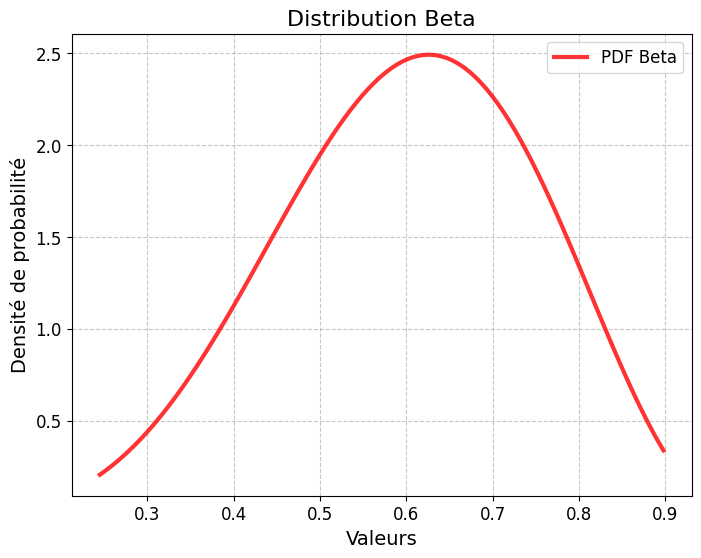

In [6]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def plot_beta_distribution(a_chapeau, b_chapeau):
    """
    Affiche un graphique de la distribution Beta avec les paramètres donnés.

    Paramètres :
    a_chapeau : float : paramètre alpha de la distribution Beta
    b_chapeau : float : paramètre beta de la distribution Beta
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    x = np.linspace(beta.ppf(0.01, a_chapeau, b_chapeau),
                    beta.ppf(0.99, a_chapeau, b_chapeau), 100)
    y = beta.pdf(x, a_chapeau, b_chapeau)

    ax.plot(x, y, 'r-', lw=3, alpha=0.8, label='PDF Beta')

    ax.set_title('Distribution Beta', fontsize=16)
    ax.set_xlabel('Valeurs', fontsize=14)
    ax.set_ylabel('Densité de probabilité', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)

    plt.show()

plot_beta_distribution(a_chapeau_bnp, b_chapeau_bnp)

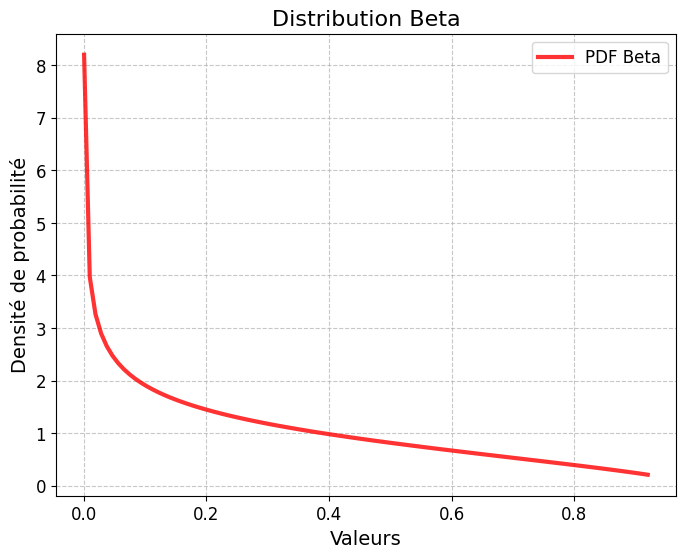

In [7]:
plot_beta_distribution(a_chapeau_sg, b_chapeau_sg)

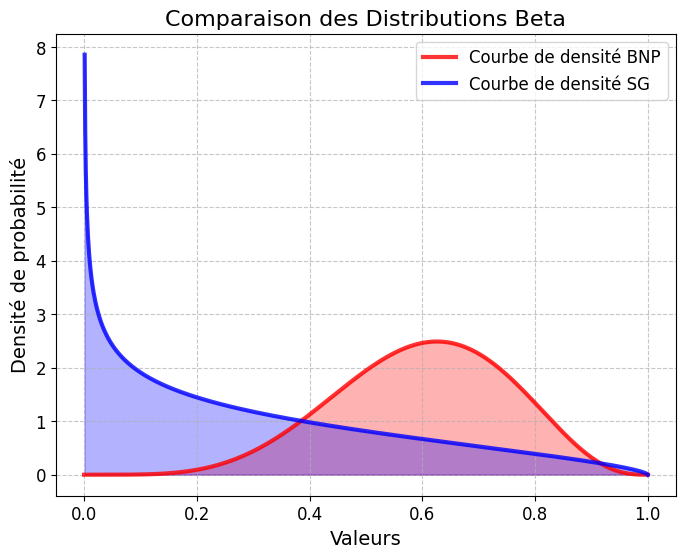

In [8]:
def plot_beta_distribution(a_chapeau_bnp, b_chapeau_bnp, a_chapeau_sg, b_chapeau_sg):
    """
    Affiche un graphique de la distribution Beta avec les paramètres donnés.
    Affiche les deux distributions Beta sur le même graphique et colorie les surfaces différemment.

    Paramètres :
    a_chapeau_bnp : float : paramètre alpha de la distribution Beta pour BNP
    b_chapeau_bnp : float : paramètre beta de la distribution Beta pour BNP
    a_chapeau_sg : float : paramètre alpha de la distribution Beta pour SG
    b_chapeau_sg : float : paramètre beta de la distribution Beta spour SG
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    x = np.linspace(0, 1, 1000)

    # Calculons des densités de probabilité pour BNP et SG
    y_bnp = beta.pdf(x, a_chapeau_bnp, b_chapeau_bnp)
    y_sg = beta.pdf(x, a_chapeau_sg, b_chapeau_sg)

    # Tracons la densité de probabilité Beta pour BNP (en rouge)
    ax.plot(x, y_bnp, 'r-', lw=3, alpha=0.8, label='Courbe de densité BNP')
    ax.fill_between(x, y_bnp, color='red', alpha=0.3)
    
    # Tracons la densité de probabilité Beta pour SG (en bleu)
    ax.plot(x, y_sg, 'b-', lw=3, alpha=0.8, label='Courbe de densité SG')
    ax.fill_between(x, y_sg, color='blue', alpha=0.3)

    ax.set_title('Comparaison des Distributions Beta', fontsize=16)
    ax.set_xlabel('Valeurs', fontsize=14)
    ax.set_ylabel('Densité de probabilité', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)
    plt.show()

plot_beta_distribution(a_chapeau_bnp, b_chapeau_bnp, a_chapeau_sg, b_chapeau_sg)


la courbe de la BNP est davantage décalée vers la droite, sa distribution est davantage concentrée vers la droite comparativement à celle de SG. Ceci suggère ainsi une meilleure performance de BNP en termes de recouvrement.

# 3. On s’intéresse à l’historique des données actions. 

---
## 3.a. Effectuer une analyse exploratoire univariée des données actions de ces deux entreprises

On s'intéresse ici à l'historique des prix bruts des actions mais également à celui des log rendements car ils representent une mesure normalisée qui permet de mieux apprecier la volatilité des prix.

Les log rendements étant définis comme suit :

$$
\text{Log Rendement} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Où :
- $ \P_t $ est le prix de l'action à l'instant  t, 
- $ \P_{t-1} $ est le prix de l'action à l'instant t-1.





In [9]:
# Chargement des données
data = pd.read_csv("data.txt", sep="\s+", header=0)
data.head()

,BNP,SG
0,42.36,55.24
1,42.72,55.59
2,43.20,56.45
3,42.67,55.55
4,41.81,54.50


### Statistiques descriptives des rendements et des log rendements.

In [10]:
## principales caractéristiques de tendances centrales et de dispersion  des prix des actions
data.describe()

,BNP,SG
count,1000.000000,1000.000000
mean,31.906254,43.532641
std,9.630129,10.007847
min,14.056200,21.667700
25%,23.450325,36.065350
50%,34.353700,46.824800
75%,40.229375,51.291675
max,48.330000,60.680000


In [11]:
## Calcul des log rendements

In [12]:
data_returns = np.log(data/data.shift(1)).dropna()
data_returns.head(3)

,BNP,SG
1,0.008463,0.006316
2,0.011173,0.015352
3,-0.012344,-0.016072


In [13]:
## principales caractéristiques de tendances centrales et de dispersion log rendements des actions
data_returns.describe()

,BNP,SG
count,999.000000,999.000000
mean,-0.000888,-0.000687
std,0.024441,0.020731
min,-0.123524,-0.098292
25%,-0.013867,-0.011830
50%,-0.000358,-0.000547
75%,0.012526,0.011223
max,0.083225,0.076478


Nous procédons ci après à des statistiques descriptives plus exhausives. Incluant notamment des test de stationnarité, l'évaluation de l'asymétrie et des niveaux d'aplatissement de nos distributions

In [14]:
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

def analyze_data(df, name="Dataset"):
    """
    Analyse les données du DataFrame fourni et retourne un DataFrame avec :
    - Statistiques descriptives
    - Tests de stationnarité (Dickey-Fuller)

    Paramètres :
    df : DataFrame : Doit contenir les colonnes 'Close' et 'Rendement'
    name : str : Nom du dataset (optionnel)

    Retourne :
    results : DataFrame avec toutes les analyses
    """
    # Vérification de la présence des colonnes nécessaires
    if not {'Close', 'Rendement'}.issubset(df.columns):
        raise ValueError("Le DataFrame doit contenir les colonnes 'Close' et 'Rendement'.")

    # Statistiques descriptives
    results = df[['Close', 'Rendement']].describe()
    results['Indicateur'] = ["Nombre", "Moyenne", "Ecart-Type", "Minimum", "Percentile 25%", "Médiane", "Percentile 75%", "Maximum"]
    results = results[['Indicateur', 'Close', 'Rendement']]

    # Test de stationnarité (Dickey-Fuller)
    _, p_value_rend = adfuller(df['Rendement'].dropna())[:2]
    _, p_value_close = adfuller(df['Close'].dropna())[:2]

    # Kurtosis 
    kurtosis_rend = df['Rendement'].dropna().kurt()
    kurtosis_close = df['Close'].dropna().kurt()

    # skewness
    skew_rend = df['Rendement'].dropna().skew()
    skew_close = df['Close'].dropna().skew()
    results = pd.concat([results, pd.DataFrame([["Stationnarité (p)", p_value_close, p_value_rend ]], columns=results.columns)])
    results = pd.concat([results, pd.DataFrame([["Asymétrie", skew_close , skew_rend ]], columns=results.columns)])
    results = pd.concat([results, pd.DataFrame([["Excess Kurtosis", kurtosis_close, kurtosis_rend ]], columns=results.columns)])
  
    return results

data_bnp = pd.concat([data["BNP"], data_returns["BNP"]], axis=1)
data_bnp.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_bnp)

,Indicateur,Close,Rendement
count,Nombre,1000.000000,999.000000
mean,Moyenne,31.906254,-0.000888
std,Ecart-Type,9.630129,0.024441
min,Minimum,14.056200,-0.123524
25%,Percentile 25%,23.450325,-0.013867
50%,Médiane,34.353700,-0.000358
75%,Percentile 75%,40.229375,0.012526
max,Maximum,48.330000,0.083225
0,Stationnarité (p),0.794391,0.000000
0,Asymétrie,-0.310893,-0.331426


In [15]:
data_sg = pd.concat([data["SG"], data_returns["SG"]], axis=1)
data_sg.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_sg)

,Indicateur,Close,Rendement
count,Nombre,1000.000000,9.990000e+02
mean,Moyenne,43.532641,-6.874575e-04
std,Ecart-Type,10.007847,2.073120e-02
min,Minimum,21.667700,-9.829201e-02
25%,Percentile 25%,36.065350,-1.182979e-02
50%,Médiane,46.824800,-5.468895e-04
75%,Percentile 75%,51.291675,1.122288e-02
max,Maximum,60.680000,7.647830e-02
0,Stationnarité (p),0.736159,8.678531e-09
0,Asymétrie,-0.489312,-1.797332e-01


#### Commentaire :

Les cours des actions de BNP et de société générale sont tous deux assez variables sur la période d'étude. Les log rendements associés sont très volatiles, avec une dispersion allant jusqu'à l'ordre de 30 fois supérieur à la valeur absolue de la moyenne


### Evolution du cours des actions de BNP et SG ainsi que celle de leurs log rendements

Cette evolution permet d'illustrer de maniere visuelle la forte volatilité des rendements des actions de BNP et de SG 

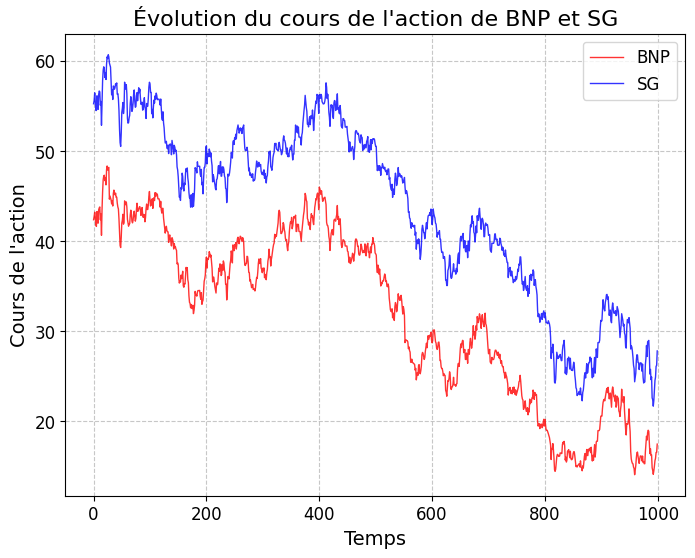

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(data["BNP"], 'r-', lw=1, alpha=0.8, label='BNP')
ax.plot(data["SG"], 'b-', lw=1, alpha=0.8, label='SG')
ax.set_title("Évolution du cours de l'action de BNP et SG", fontsize=16)
ax.set_xlabel('Temps', fontsize=14)
ax.set_ylabel("Cours de l'action", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best', fontsize=12)
plt.show()

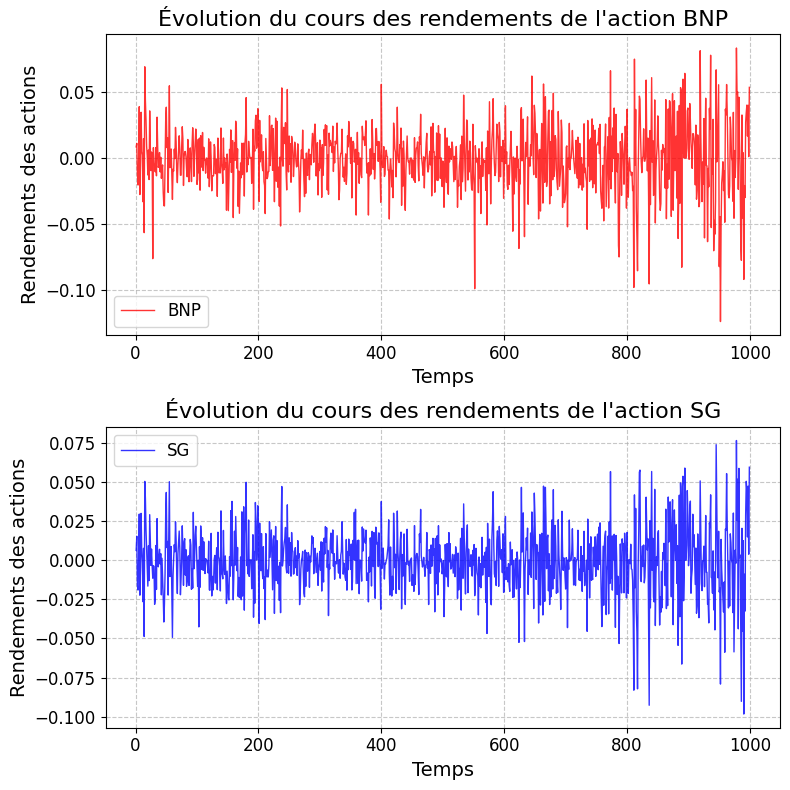

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Graphique pour BNP
ax1.plot(data_returns["BNP"], 'r-', lw=1, alpha=0.8, label='BNP')
ax1.set_title("Évolution du cours des rendements de l'action BNP", fontsize=16)
ax1.set_xlabel('Temps', fontsize=14)
ax1.set_ylabel("Rendements des actions", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='best', fontsize=12)

# Graphique pour SG
ax2.plot(data_returns["SG"], 'b-', lw=1, alpha=0.8, label='SG')
ax2.set_title("Évolution du cours des rendements de l'action SG", fontsize=16)
ax2.set_xlabel('Temps', fontsize=14)
ax2.set_ylabel("Rendements des actions", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()


## 3.b Modéliser judicieusement les distributions univariées des facteurs de risques

#### Histogrammes et courbes de densité des log rendements des actions de BNP et SG

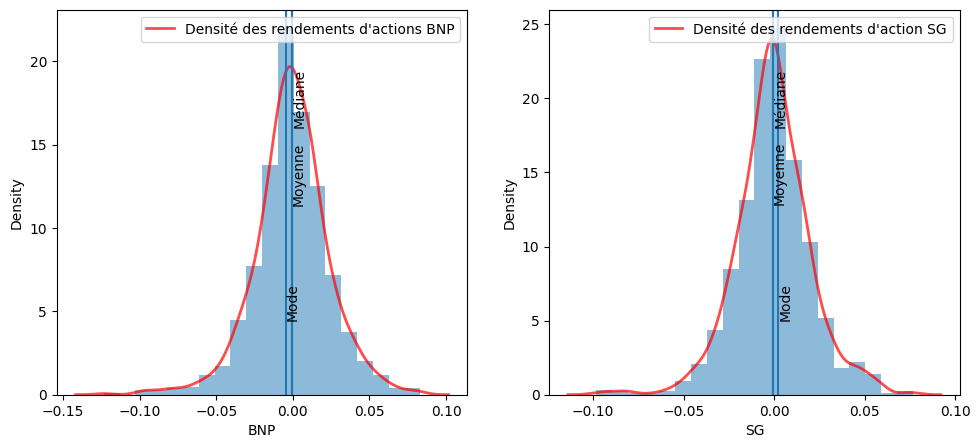

In [18]:

def HistogPlot(data, label):
    sns.kdeplot(data, color = "r", lw=2, alpha=0.7, label=label)  # Density
    n, bins, patches = plt.hist(
        data, bins=20, density=True, histtype="stepfilled", alpha=0.5
    )  # Histogram
    
    
    ymax = plt.ylim()[1]  # Get the max y value for positioning text

    # Ajout de la moyenne
    plt.axvline(x=np.mean(data))
    plt.text(np.mean(data), ymax * 0.5, "Moyenne", rotation=90)

    # Ajout de la médiane
    plt.axvline(x=np.median(data))
    plt.text(np.median(data), ymax * 0.7, "Médiane", rotation=90)

    # Adjout du mode
    plt.axvline(x=(bins[n.argmax()] + bins[n.argmax() + 1]) / 2)
    plt.text((bins[n.argmax()] + bins[n.argmax() + 1]) / 2, ymax * 0.2, "Mode", rotation=90)
    plt.legend()


# Plot
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(131)
HistogPlot(data_returns["BNP"], "Densité des rendements d'actions BNP")
ax2 = plt.subplot(132)
HistogPlot(data_returns["SG"], "Densité des rendements d'action SG")
plt.show()

Dans les deux cas on observe des courbes en forme de cloche, et sensiblement symétrique, ce qui laisse présager une loi normale. Mais les kurtosis excessifs sont supérieurs à 2 et donc des kurtosis supérieurs à 5. Nous allons donc modéliser en plus des lois gaussiennes des lois à queues lourdes, notamment une Student et une Skew Student.

### Modélisation des lois marginales associées aux log rendements

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, t, kstest, skew

from skew_student import*  # Import de la Skew-Student

def modeliser_distribution(data):
    """
    Modélise une distribution normale, Student et Skew-Student, compare les ajustements et sélectionne la meilleure.
    
    Paramètre :
    - data : array NumPy contenant l'échantillon de données.
    
    Retour :
    - Un dictionnaire contenant la distribution sélectionnée et les p-values du KS test.
    """
    
    #  1. Estimation des paramètres
    mu_norm, sigma_norm = norm.fit(data)  # Loi normale
    df_t, loc_t, scale_t = t.fit(data)  # Loi de Student
    mu_skew, sigma_skew, gamma_skew, nu_skew = optimize_parameters(data)  # Loi Skew-Student
    
    print("--"*10,"PARAMETRES ESTIMES", "--"*10)
    print(f"Loi Normale - Moyenne: {mu_norm:.3f}, Écart-type: {sigma_norm:.3f}")
    print(f"Loi de Student - df: {df_t:.3f}, Moyenne: {loc_t:.3f}, Échelle: {scale_t:.3f}")
    print(f"Loi Skew-Student - μ: {mu_skew:.3f}, σ: {sigma_skew:.3f}, γ: {gamma_skew:.3f}, ν: {nu_skew:.3f}")
    print("--"*30)
    
    #  2. Affichage des Q-Q Plots juxtaposés
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 3 colonnes pour ajouter la Skew-Student

    # Q-Q Plot pour la loi Normale
    stats.probplot(data, dist="norm", sparams=(mu_norm, sigma_norm), plot=axes[0])
    axes[0].set_title("Q-Q Plot - Loi Normale")
    axes[0].grid()

    # Q-Q Plot pour la loi de Student
    stats.probplot(data, dist="t", sparams=(df_t, loc_t, scale_t), plot=axes[1])
    axes[1].set_title("Q-Q Plot - Loi de Student")
    axes[1].grid()

    # Q-Q Plot pour la loi Skew-Student
    sorted_data = np.sort(data)
    n = len(data)
    quantiles_skew = skew_student_ppf((np.arange(1, n + 1) - 0.5) / n, mu_skew, sigma_skew, gamma_skew, nu_skew)

    axes[2].scatter(quantiles_skew, sorted_data, color="blue", alpha=0.6)
    axes[2].plot(quantiles_skew, quantiles_skew, 'r--')  # Ligne théorique (y=x)
    axes[2].set_title("Q-Q Plot - Loi Skew-Student")
    axes[2].grid()

    plt.tight_layout()
    plt.show()
    
    #  3. Test KS (Kolmogorov-Smirnov)
    ks_stat_norm, ks_pval_norm = kstest(data, "norm", args=(mu_norm, sigma_norm))
    ks_stat_t, ks_pval_t = kstest(data, "t", args=(df_t, loc_t, scale_t))
    
    # KS-Test pour la Skew-Student
    np.random.seed(42)
    sim_data = skew_student_sim(mu_skew, sigma_skew, gamma_skew, nu_skew, size = 100_000)
    ks_stat_skew, ks_pval_skew =  kstest(data,sim_data)

    print(f"KS Test - Loi Normale: Stat={ks_stat_norm:.3f}, p-value={ks_pval_norm:.3f}")
    print(f"KS Test - Loi de Student: Stat={ks_stat_t:.3f}, p-value={ks_pval_t:.3f}")
    print(f"KS Test - Loi Skew-Student: Stat={ks_stat_skew:.3f}, p-value={ks_pval_skew:.3f}")

    #  4. Sélection de la meilleure distribution
    p_values = {"Normale": ks_pval_norm, "Student": ks_pval_t, "Skew-Student": ks_pval_skew}
    best_dist = max(p_values, key=p_values.get)  # Sélectionne la distribution avec la plus grande p-value
    print(f" Distribution sélectionnée: {best_dist}")
    
    return {
        "Distribution": best_dist, 
        "p-value Normale": ks_pval_norm, 
        "p-value Student": ks_pval_t, 
        "p-value Skew-Student": ks_pval_skew
    }


Modélisation des rendements des actions BNP



d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


-------------------- PARAMETRES ESTIMES --------------------
Loi Normale - Moyenne: -0.001, Écart-type: 0.024
Loi de Student - df: 4.533, Moyenne: -0.001, Échelle: 0.019
Loi Skew-Student - μ: 0.002, σ: 0.019, γ: -0.152, ν: 4.587
------------------------------------------------------------


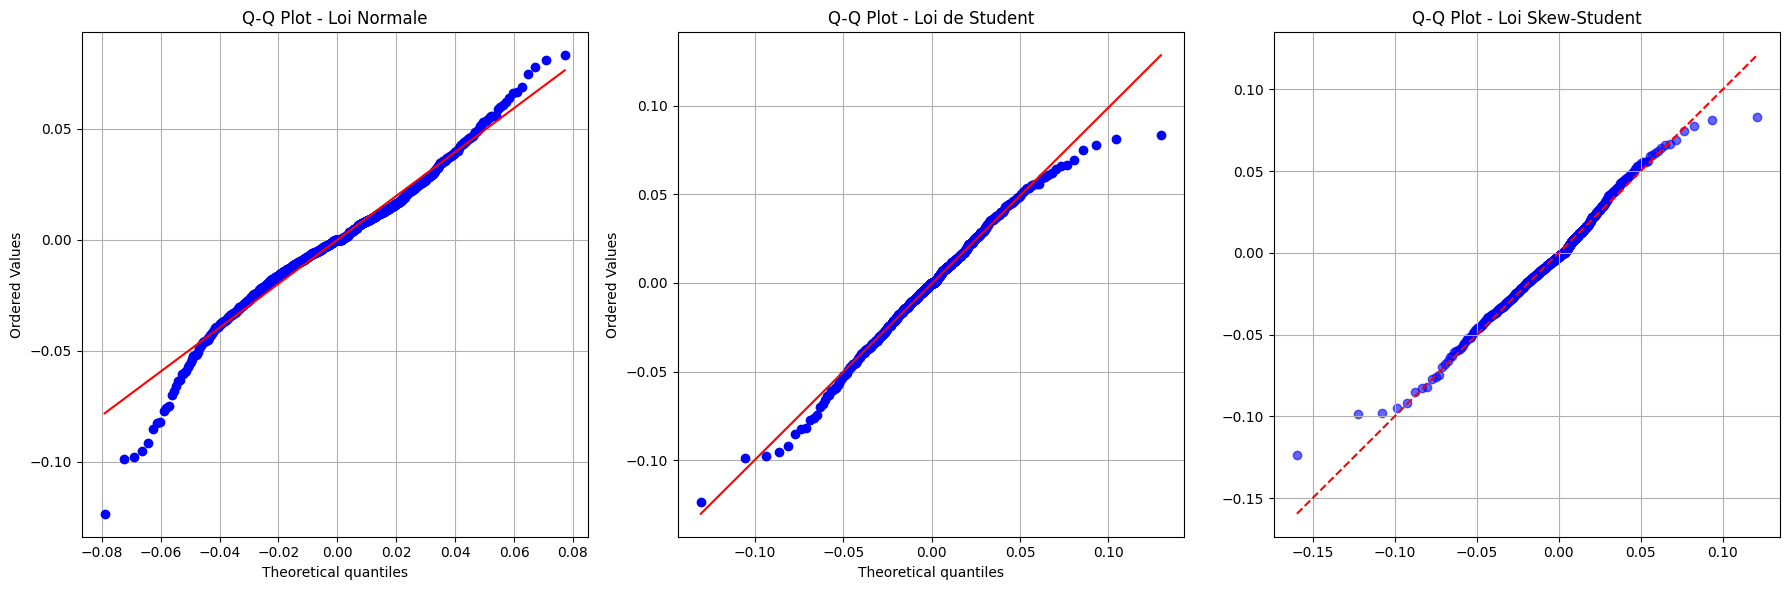

KS Test - Loi Normale: Stat=0.055, p-value=0.004
KS Test - Loi de Student: Stat=0.026, p-value=0.487
KS Test - Loi Skew-Student: Stat=0.023, p-value=0.681
 Distribution sélectionnée: Skew-Student
------------------------------------------------------------ 

Modélisation des rendements des actions SG

-------------------- PARAMETRES ESTIMES --------------------
Loi Normale - Moyenne: -0.001, Écart-type: 0.021
Loi de Student - df: 4.593, Moyenne: -0.001, Échelle: 0.016
Loi Skew-Student - μ: -0.002, σ: 0.016, γ: 0.073, ν: 4.585
------------------------------------------------------------


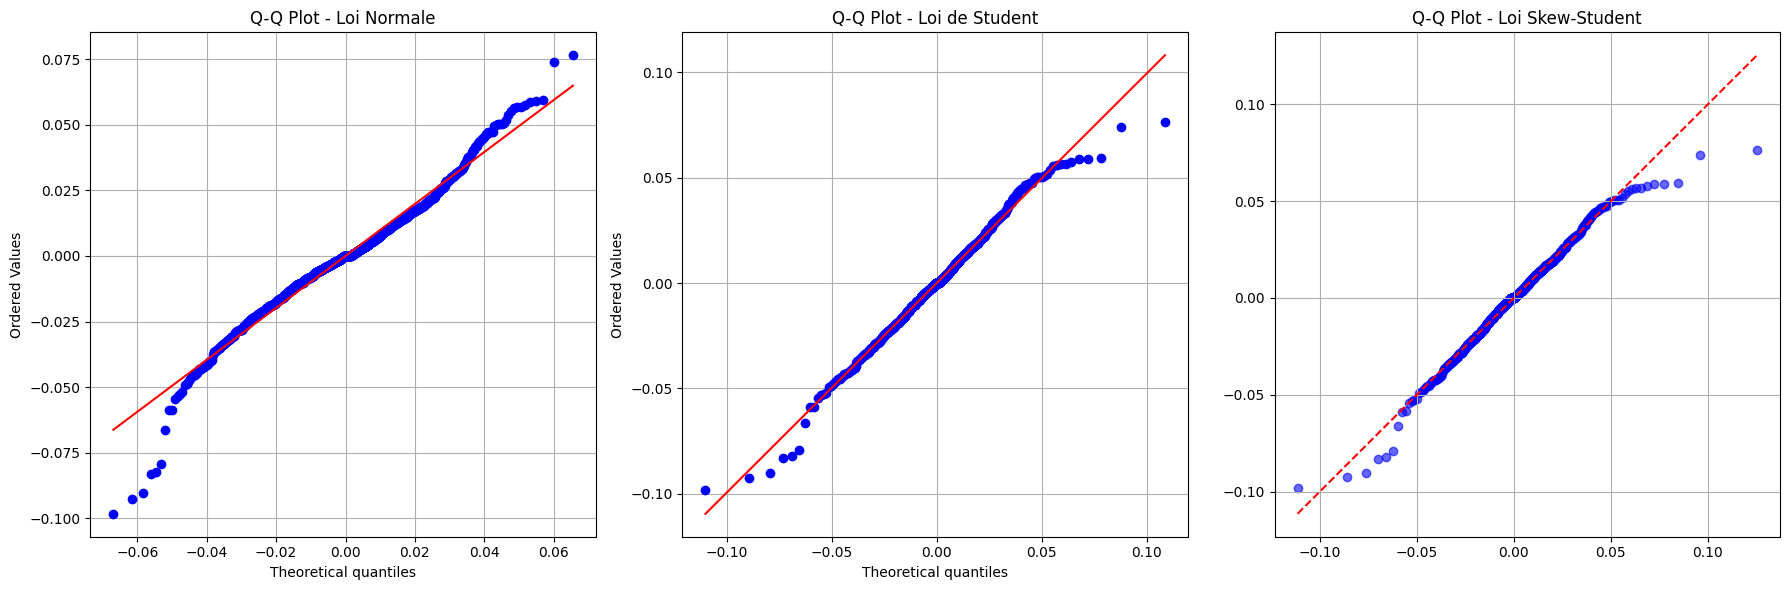

KS Test - Loi Normale: Stat=0.049, p-value=0.015
KS Test - Loi de Student: Stat=0.025, p-value=0.559
KS Test - Loi Skew-Student: Stat=0.029, p-value=0.373
 Distribution sélectionnée: Student


In [20]:
from skew_student import *
from scipy.stats import kstest, norm, t, ks_2samp

# Modélisation des rendement 
print("Modélisation des rendements des actions BNP\n")
resultats_BNP = modeliser_distribution(data_returns["BNP"])

print("--"*30,"\n")

print("Modélisation des rendements des actions SG\n")
resultats_SG = modeliser_distribution(data_returns["SG"])



#### Commentaire 

A la lecture des QQ_plot, et à l'issu des tests d'adéquation de Kolmogorov smirnov:

- les rendements de BNP s'ajustent mieux à l'aide d'une skew-student (confirmation par le test de Kolmogorov-Smirnov, p-value = 0.68). Toutefois les queues de distribution semblent ne pas être bien ajustées.
- les rendements de SG s'ajustent aussi bien à l'aide d'une skew-student qu'à l'aide d'une student. Nous privilégions donc un modèle simple en retenant une student (p-value = 0.559, ks-test).

# 4. Étudier la structure de dépendance entre les facteurs de risques sur la base de critères non paramétriques.

Pour ce faire, nous utilisons les outils suivant:

- le dépendogramme,
- le coefficient de spearman
- le taux de Kendall


### Coefficient de Spearmann et taux de Kendall

In [21]:
from scipy.stats import kendalltau, spearmanr
data_uniform = data_returns.rank(method='average', pct=True)

# Calcul du tau de Kendall
tau, p_value_tau = kendalltau(data_uniform['BNP'], data_uniform['SG'])

# Calcul du coefficient de Spearman
spearman_corr, p_value_spearman = spearmanr(data_uniform['BNP'], data_uniform['SG'])

print(f"Tau de Kendall: {tau:.4f} (p-value: {p_value_tau:.4f})")
print(f"Coefficient de Spearman: {spearman_corr:.4f} (p-value: {p_value_spearman:.4f})")


Tau de Kendall: 0.6691 (p-value: 0.0000)
Coefficient de Spearman: 0.8410 (p-value: 0.0000)


#### Commentaire:
Les coefficients de corrélation de Kendall  et de Spearman révèlent une concordance significative entre les log-rendements de BNP et de Société Générale. Ces résultats indiquent que les deux séries temporelles évoluent généralement dans la même direction.

## Dépendogramme

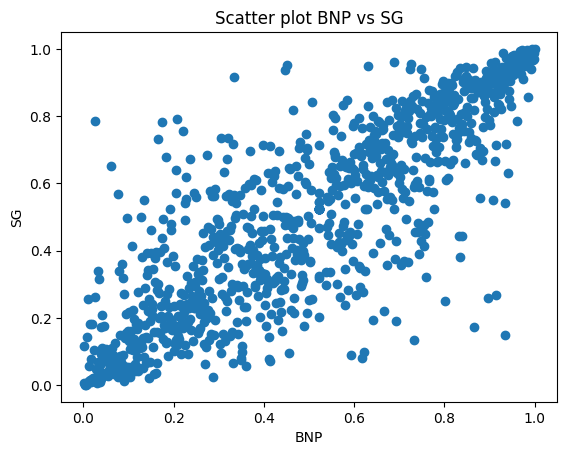

In [22]:
data_uniform = data_returns.rank(method='average', pct=True)
# Nuage de points
plt.scatter(data_uniform['BNP'], data_uniform['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()

#### L'analyse du dépendodogramme suggère une dependance de queue dans nos données principalement marquée à droite.

# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes :

## 5.a. Copules elliptiques : gaussienne, Student. 

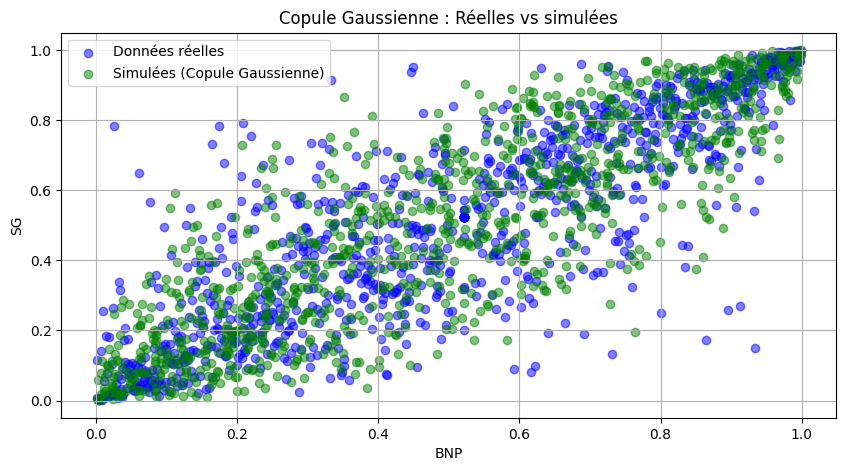

In [47]:
from copulae import GaussianCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Gaussienne sur les rangs
copula_gaussian = GaussianCopula(dim=2)  # 2 variables
copula_gaussian.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_gaussian.random(len(data_returns))

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument les pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(rank_data['BNP'], rank_data['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Simulées (Copule Gaussienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gaussienne : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
copula_gaussian.summary()

1.000000,0.860948
0.860948,1.000000


# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes : 

## Copules elliptiques : gaussienne, Student.

In [53]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist
from scipy.optimize import minimize
from math import log, gamma, pi, sqrt

# =============================================================================
# 1) Fonctions de densité t-Student (univariée & bivariée) en log
# =============================================================================

def log_t_pdf_univariate(x, df):
    """
    Retourne ln[f_nu(x)] pour la loi t univariée de df degrés de liberté.
    Formule :
      f_nu(x) = Gamma((df+1)/2) / [ sqrt(df*pi)*Gamma(df/2) ] * [1 + x^2/df]^(-(df+1)/2)
    """
    c1 = np.log(gamma((df+1)/2)) - np.log(gamma(df/2)) - 0.5*np.log(df*pi)
    c2 = -(df+1)/2 * np.log(1 + x**2/df)
    return c1 + c2

def log_t_pdf_bivariate(x, y, df, r):
    """
    Retourne ln[f_{df,r}(x,y)] pour la t-Student bivariée, corrélation r, df degrés de liberté.

      f_{df,r}(x,y) =
         Gamma((df+2)/2) / [ Gamma(df/2) * (pi*df) * sqrt(1-r^2) ]
         * [1 + 1/df * (x^2 - 2rxy + y^2)/(1-r^2)]^(-(df+2)/2)

    On renvoie le log de cette densité.
    """
    # Partie constante
    log_num_gamma = np.log(gamma((df+2)/2)) - np.log(gamma(df/2))
    log_denom = np.log(pi*df) + 0.5*np.log(1 - r**2)
    cst = log_num_gamma - log_denom

    # Partie quadratique
    quad = (x**2 - 2*r*x*y + y**2)/(1 - r**2)
    log_noyau = - (df+2)/2 * np.log(1 + quad/df)

    return cst + log_noyau

# =============================================================================
# 2) Log-densité de la copule t-Student (bivariée)
# =============================================================================

def log_student_copula_2d(u1, u2, df, r):
    """
    Calcule ln[c_{df,r}(u1,u2)] = ln f_{df,r}(x,y) - [ln f_df(x) + ln f_df(y)],
    où x = t_{df}^{-1}(u1) et y = t_{df}^{-1}(u2).

    - u1, u2 dans [0,1].
    - df > 0, r in (-1,1).
    """
    # Inversion via la quantile function (ppf) univariée
    x = t_dist.ppf(u1, df)
    y = t_dist.ppf(u2, df)

    # Log densité jointe
    log_joint = log_t_pdf_bivariate(x, y, df, r)
    # Log densités marginales (univariées)
    log_marg_x = log_t_pdf_univariate(x, df)
    log_marg_y = log_t_pdf_univariate(y, df)

    return log_joint - (log_marg_x + log_marg_y)

# =============================================================================
# 3) Log-vraisemblance négative
# =============================================================================

def negative_log_likelihood(params, data):
    """
    Calcule - somme [ ln c_{df,r}(u1,u2) ] sur tout l'échantillon.
    data : array shape (n,2) contenant les (u1,u2) dans [0,1].
    params : (alpha, beta) --> r, df via reparamétrage :

      r  = tanh(alpha)   --> r in (-1,1)
      df = 2 + log(1 + exp(beta))  --> df > 2 (par exemple)
    """
    alpha, beta = params
    r = np.tanh(alpha)  # in (-1,1)
    df = 2.0 + np.log1p(np.exp(beta))  # > 2

    ll = 0.0
    for (u1, u2) in data:
        ll += log_student_copula_2d(u1, u2, df, r)

    return -ll  # On renvoie la -log-vraisemblance

# =============================================================================
# 4) Fonction d'ajustement (fit) par MLE
# =============================================================================

def fit_student_copula_2d(data, alpha0=0.0, beta0=1.0):
    """
    Ajuste la copule t-Student bivariée à un échantillon de pseudo-observations 'data' (n,2).
    Minimisation de la -log-vraisemblance w.r.t. (alpha,beta).
      alpha0, beta0 : valeurs initiales pour (alpha, beta).

    Retourne un dict contenant r, df, logLik, etc.
    """
    res = minimize(
        fun=negative_log_likelihood,
        x0=np.array([alpha0, beta0]),
        args=(data,),
        method='Nelder-Mead'
    )
    alpha_hat, beta_hat = res.x
    r_hat = np.tanh(alpha_hat)
    df_hat = 2.0 + np.log1p(np.exp(beta_hat))

    ll_hat = -res.fun  # log-vraisemblance au point optimum

    return {
        'r': r_hat,
        'df': df_hat,
        'logLik': ll_hat,
        'success': res.success,
        'message': res.message
    }

# =============================================================================
# 5) Utilisation sur données data_returns
# =============================================================================

# 1) Transformer vos rendements en pseudo-observations dans [0,1]
rank_data = data_returns.rank(method='average') / (len(data_returns) + 1)
u_data = rank_data.values  # numpy array de taille (n,2)

# 2) Ajustement de la copule t-Student bivariée par MLE
result = fit_student_copula_2d(u_data, alpha0=0.0, beta0=1.0)

print("=== Estimation Copule t-Student Bivariée ===")
print(f"Paramètre r estimé = {result['r']:.4f}")
print(f"Paramètre df estimé = {result['df']:.4f}")
print(f"Log-vraisemblance  = {result['logLik']:.4f}")
print("Convergence :", result['success'], "|", result['message'])

=== Estimation Copule t-Student Bivariée ===
Paramètre r estimé = 0.8496
Paramètre df estimé = 2.0000
Log-vraisemblance  = 719.7436
Convergence : True | Optimization terminated successfully.


In [55]:
from copulae import GaussianCopula, StudentCopula, GumbelCopula, FrankCopula, ClaytonCopula
from scipy.stats import kendalltau, spearmanr

# Chargement des données
data_returns = data_returns.reset_index(drop=True)

# Transformation en pseudo-observations (rangs normalisés)
rank_data = data_returns.rank() / (len(data_returns) + 1)

# Définition des copules
copules = {
    "Gaussian": GaussianCopula(dim=2),
    "Student-t": StudentCopula(dim=2, df=2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2),
    "Clayton": ClaytonCopula(dim=2)
}

# Ajustement des copules aux données empiriques
fit_results = {}
for name, cop in copules.items():
    if name == "Student-t":
        cop.fit(rank_data.values, fix_df=True)
    else:
        cop.fit(rank_data.values)
    fit_results[name] = cop

# Comparaison des mesures de dépendance
empirical_tau, _ = kendalltau(data_returns["BNP"], data_returns["SG"])
empirical_rho, _ = spearmanr(data_returns["BNP"], data_returns["SG"])

results = []
for name, cop in fit_results.items():
    simulated_data = cop.random(len(data_returns))
    sim_tau, _ = kendalltau(simulated_data[:, 0], simulated_data[:, 1])
    sim_rho, _ = spearmanr(simulated_data[:, 0], simulated_data[:, 1])
    
    # Nouveau calcul de la log-vraisemblance via la densité jointe
    log_likelihood = np.sum(np.log(cop.pdf(rank_data.values)))

    results.append([name, log_likelihood, abs(sim_tau - empirical_tau), abs(sim_rho - empirical_rho)])

# Affichage des résultats
results_df = pd.DataFrame(results, columns=["Copule", "Log-Vraisemblance", "Erreur Kendall Tau", "Erreur Spearman Rho"])
print(results_df.sort_values(by="Log-Vraisemblance", ascending=False))

      Copule  Log-Vraisemblance  Erreur Kendall Tau  Erreur Spearman Rho
1  Student-t         720.838328            0.014937             0.018215
2     Gumbel         703.146279            0.001858             0.006827
0   Gaussian         670.141798            0.009589             0.008106
3      Frank         630.219249            0.009095             0.011508
4    Clayton         517.723513            0.126423             0.112160


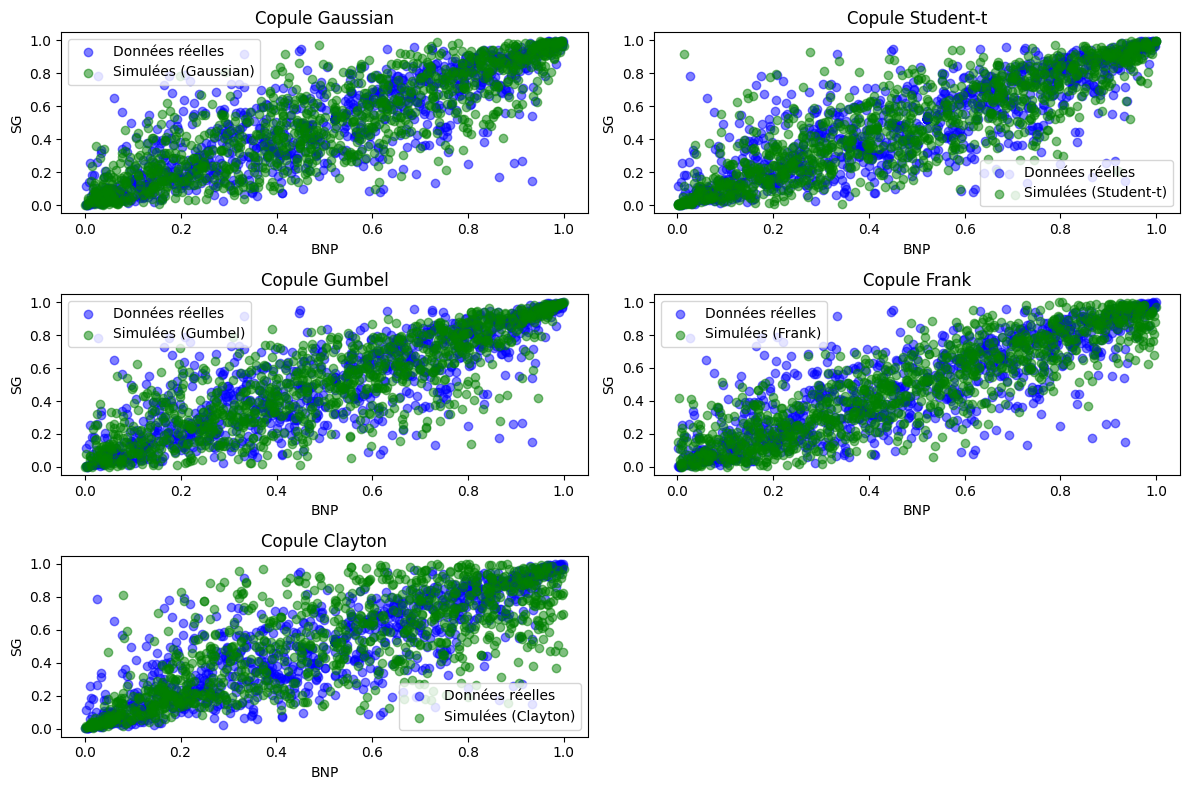

In [56]:
# Visualisation des distributions simulées
plt.figure(figsize=(12, 8))
for i, (name, cop) in enumerate(fit_results.items(), 1):
    simulated_data = cop.random(len(data_returns))
    plt.subplot(3, 2, i)
    plt.scatter(rank_data["BNP"], rank_data["SG"], alpha=0.5, label="Données réelles", color="blue")
    plt.scatter(simulated_data[:, 0], simulated_data[:, 1], alpha=0.5, label=f"Simulées ({name})", color="green")
    plt.title(f"Copule {name}")
    plt.xlabel("BNP")
    plt.ylabel("SG")
    plt.legend()

plt.tight_layout()
plt.show()

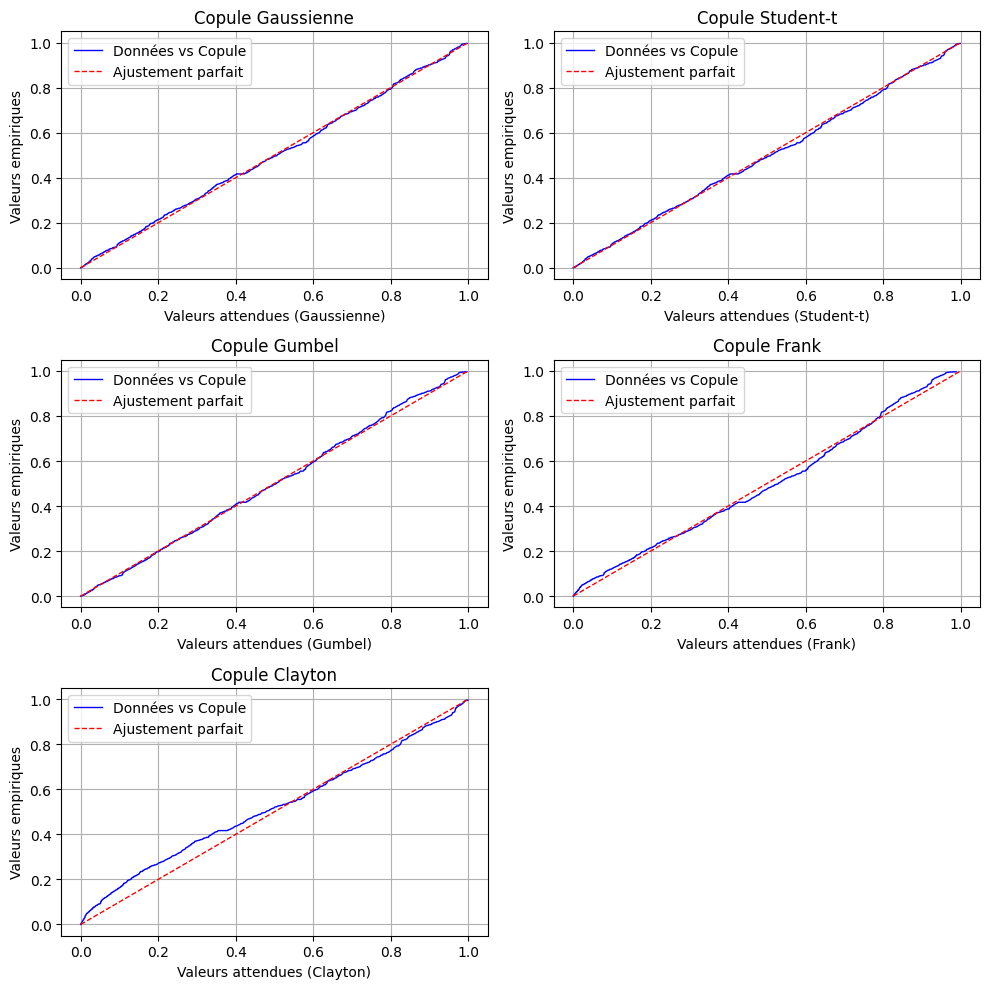

In [57]:
from scipy.stats import gaussian_kde

rank_data = data_returns.rank() / (len(data_returns) + 1)
u = rank_data.iloc[:, 0].values
v = rank_data.iloc[:, 1].values
n = len(u)

# Calcul de la statistique empirique V_i (distribution de Kendall)
mask = (u[:, np.newaxis] <= u) & (v[:, np.newaxis] <= v)
counts = mask.sum(axis=1)
V = (counts - 1) / (n - 1)  # Ajustement pour l'auto-comparaison
V_trié = np.sort(V)

# Définition des copules à tester
copules = {
    "Gaussienne": GaussianCopula(dim=2),
    "Student-t": StudentCopula(dim=2, df=2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2),
    "Clayton": ClaytonCopula(dim=2)
}

# Paramètres de simulation
nb_simulations = 100  # Augmenter pour un résultat plus lisse

# Génération des graphiques de Kendall
plt.figure(figsize=(10, 10))

for i, (nom, copule) in enumerate(copules.items(), 1):
    # Ajustement de la copule aux données
    if nom == "Student-t":
        copule.fit(rank_data.values, fix_df=True)
    else:
        copule.fit(rank_data.values)
    
    # Simulation de plusieurs jeux de données et calcul des statistiques V
    V_simulé = np.zeros((nb_simulations, n))
    
    for s in range(nb_simulations):
        # Génération de données synthétiques à partir de la copule ajustée
        données_simulées = copule.random(n)
        
        # Calcul de V pour les données simulées
        u_sim = données_simulées[:, 0]
        v_sim = données_simulées[:, 1]
        mask_sim = (u_sim[:, np.newaxis] <= u_sim) & (v_sim[:, np.newaxis] <= v_sim)
        counts_sim = mask_sim.sum(axis=1)
        V_sim = (counts_sim - 1) / (n - 1)
        V_simulé[s] = np.sort(V_sim)  # Tri des valeurs simulées
    
    # Calcul des valeurs moyennes attendues à partir des simulations
    V_attendu = V_simulé.mean(axis=0)
    
    # Tracé du graphique de Kendall avec une ligne fine pour mieux voir l'ajustement
    plt.subplot(3, 2, i)
    plt.plot(V_attendu, V_trié, lw=1, color='blue', label='Données vs Copule')
    plt.plot([0, 1], [0, 1], '--r', lw=1, label='Ajustement parfait')
    plt.xlabel(f'Valeurs attendues ({nom})')
    plt.ylabel('Valeurs empiriques')
    plt.title(f'Copule {nom}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

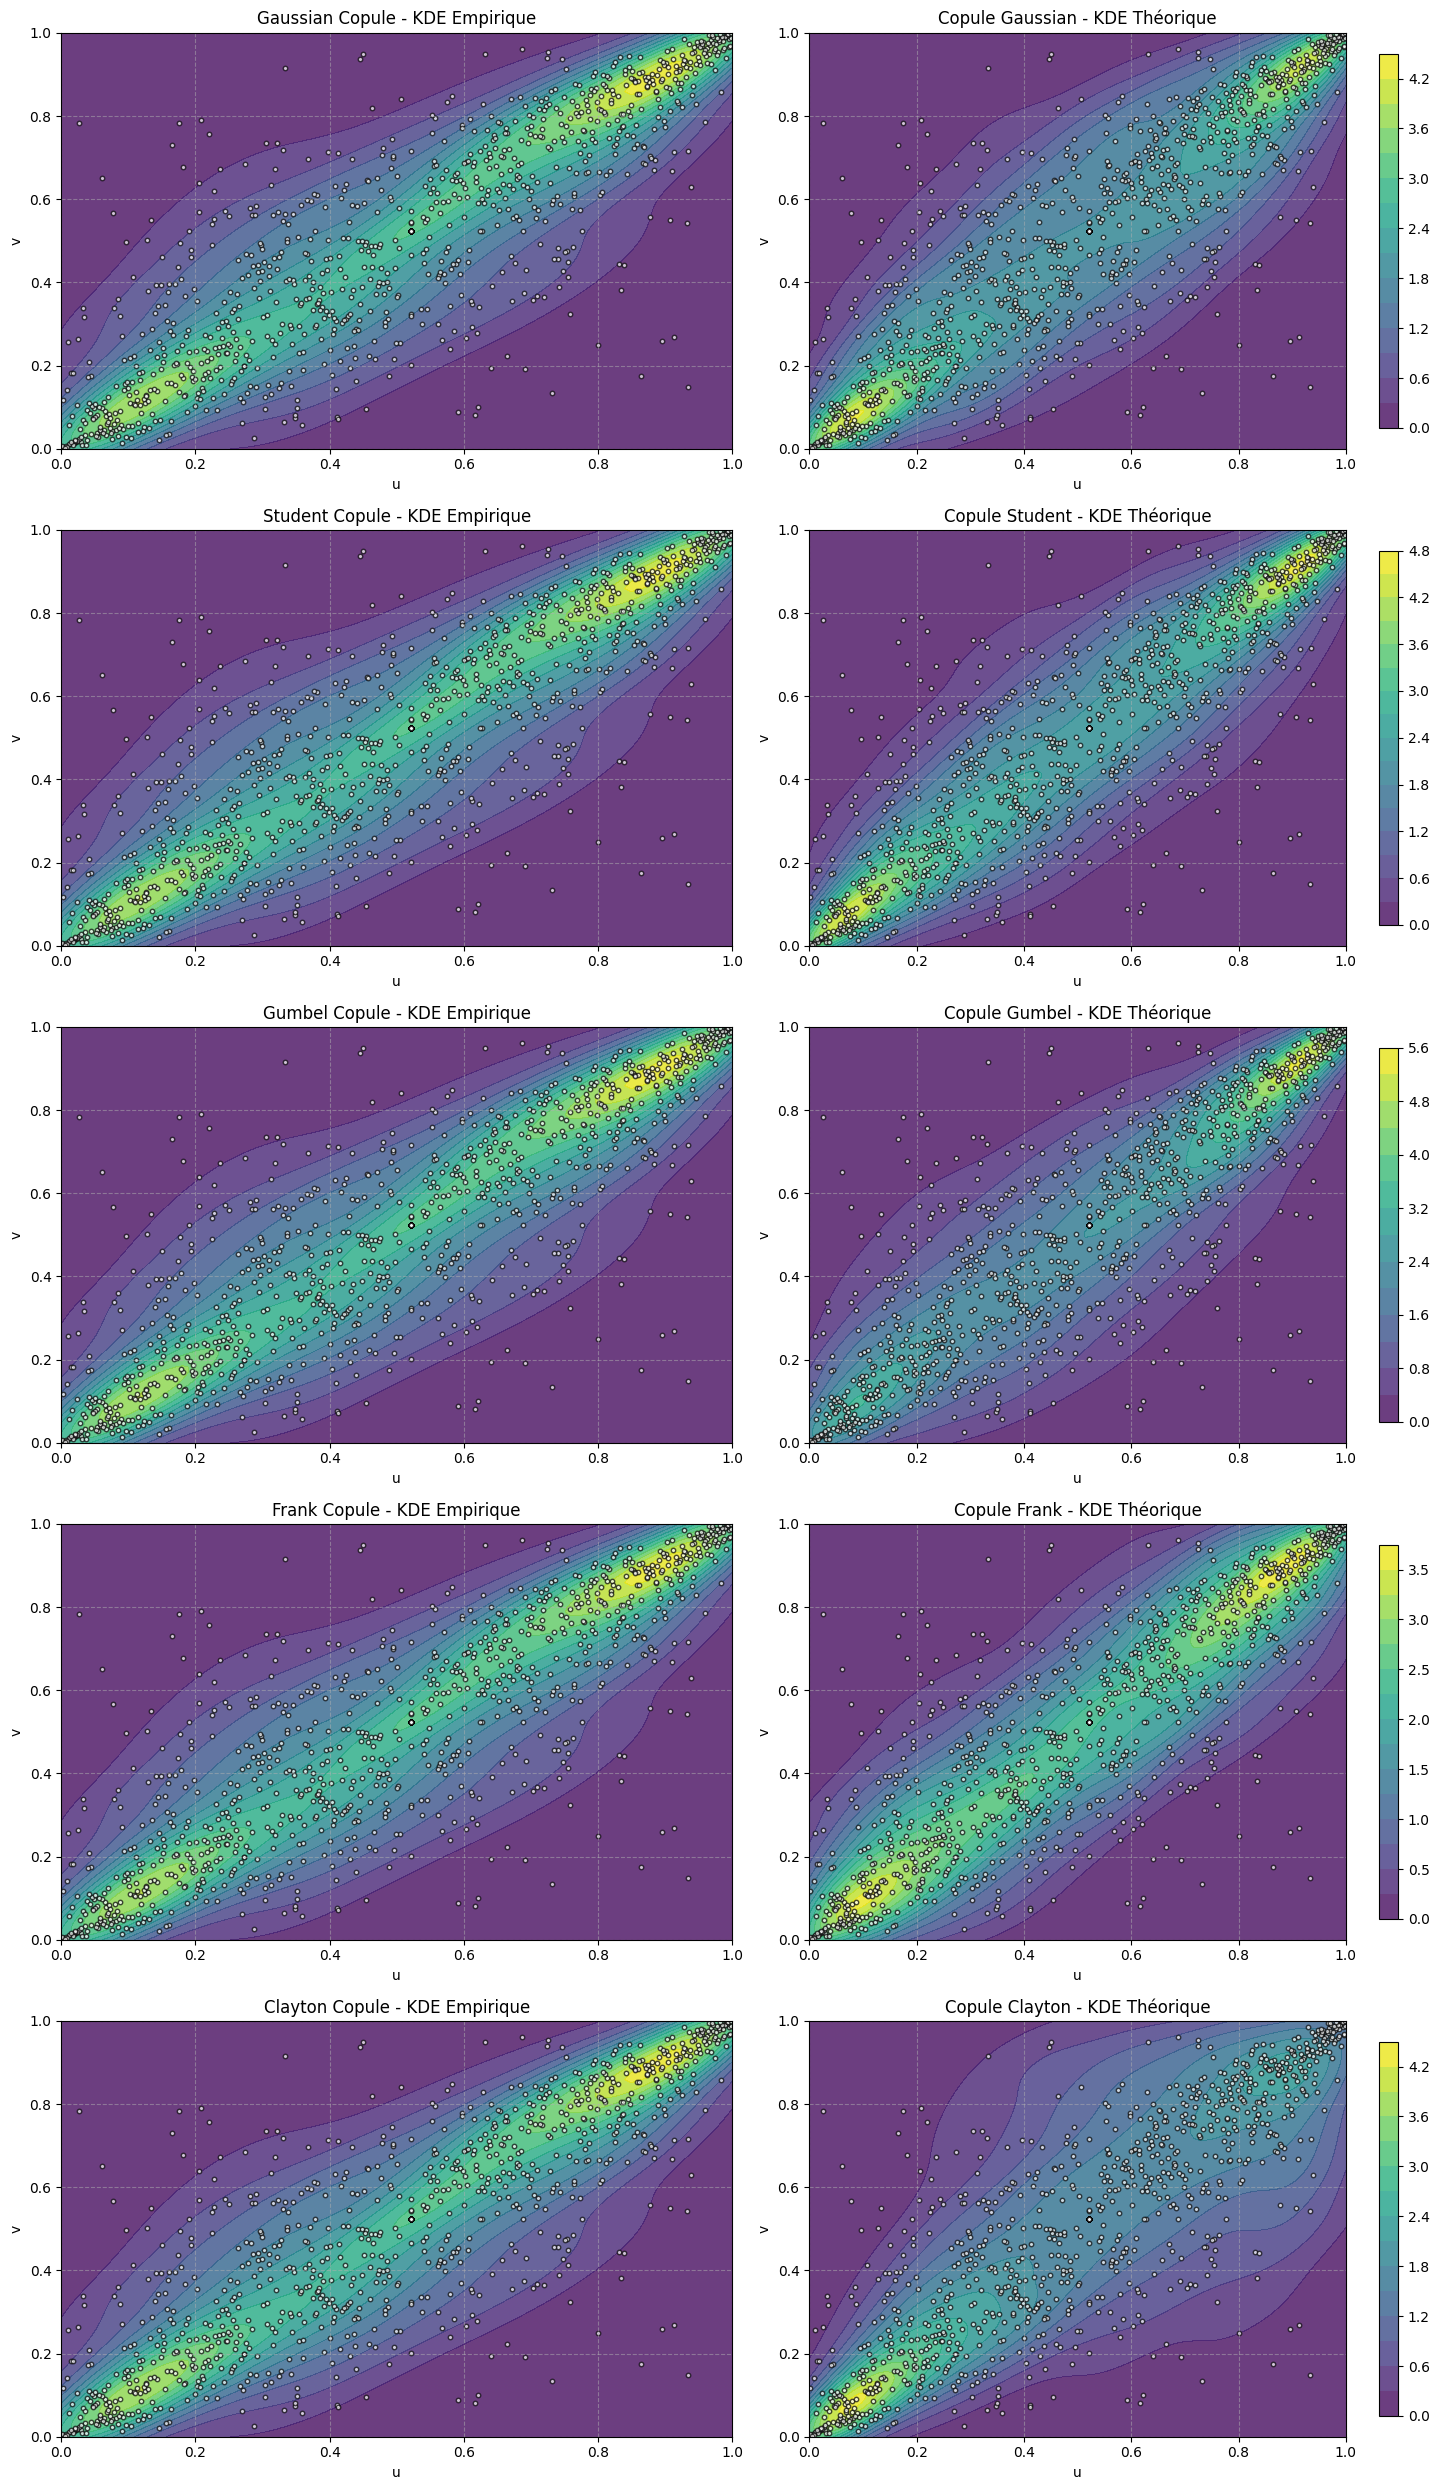

In [42]:
from scipy.stats import gaussian_kde

# Configuration
grid_size = 100        # Résolution de la grille
contour_levels = 15    # Nombre de niveaux de contour

# Préparation des données : transformation en marges uniformes par rang
rank_data = data_returns.rank() / (len(data_returns) + 1)
u = rank_data.iloc[:, 0]
v = rank_data.iloc[:, 1]

# Création de la grille d'évaluation
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Calcul de la KDE empirique sur les données observées
empirical_kernel = gaussian_kde(rank_data.values.T)
Z_empirical = empirical_kernel(grid_points.T).reshape(X.shape)

# Définition des copules à comparer
copulas = {
    "Gaussian": GaussianCopula(dim=2),
    "Student": StudentCopula(dim=2, df=2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2),
    "Clayton": ClaytonCopula(dim=2)
}

# Nombre d'observations simulées pour estimer la KDE théorique
n_sim = 5000

# Création de la figure avec une ligne par copule et 2 colonnes (empirique vs théorique)
fig, axs = plt.subplots(nrows=len(copulas), ncols=2, figsize=(15, 25))
plt.subplots_adjust(hspace=0.4)

for idx, (name, copula) in enumerate(copulas.items()):
    # Ajustement de la copule aux données
    if name == "Student":
        copula.fit(rank_data.values, fix_df=True)
    else:
        copula.fit(rank_data.values)
    
    # Simulation d'un échantillon théorique à partir de la copule ajustée
    simulated_data = copula.random(n_sim)
    
    # Calcul de la KDE théorique à partir de l'échantillon simulé
    theoretical_kernel = gaussian_kde(simulated_data.T)
    Z_theoretical = theoretical_kernel(grid_points.T).reshape(X.shape)
    
    # Affichage de la KDE empirique
    ax_emp = axs[idx, 0]
    cf_emp = ax_emp.contourf(X, Y, Z_empirical, levels=contour_levels, cmap='viridis', alpha=0.8)
    ax_emp.scatter(u, v, s=10, color='white', edgecolors='black', alpha=0.7)
    ax_emp.set_title(f'{name} Copule - KDE Empirique')
    ax_emp.set_xlabel('u')
    ax_emp.set_ylabel('v')
    ax_emp.grid(True, linestyle='--', alpha=0.5)
    
    # Affichage de la KDE théorique
    ax_theo = axs[idx, 1]
    cf_theo = ax_theo.contourf(X, Y, Z_theoretical, levels=contour_levels, cmap='viridis', alpha=0.8)
    ax_theo.scatter(u, v, s=10, color='white', edgecolors='black', alpha=0.7)
    ax_theo.set_title(f'Copule {name} - KDE Théorique')
    ax_theo.set_xlabel('u')
    ax_theo.set_ylabel('v')
    ax_theo.grid(True, linestyle='--', alpha=0.5)
    
    # Ajout d'une colorbar pour le graphique théorique
    fig.colorbar(cf_theo, ax=ax_theo, orientation='vertical', shrink=0.9)

plt.tight_layout()
plt.show()

NameError: name 'kernel' is not defined

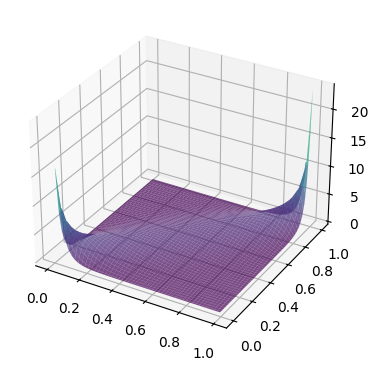

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

for idx, (name, copula) in enumerate(copulas.items(), 1):
    # Calcul de la densité théorique
    # Fit copula to data
    if name == "Student":
        copula.fit(rank_data.values, fix_df = True)
    else:
        copula.fit(rank_data.values)
        
    pdf = copula.pdf(grid_points).reshape(X.shape)
    
    # Graphique 3D
    ax = fig.add_subplot(3, 2, idx, projection='3d')
    ax.plot_surface(X, Y, pdf, cmap='viridis', alpha=0.7)
    ax.scatter(u, v, kernel([u, v]), c='red', s=10, label='Données')
    ax.set_title(f'Densité {name} Copula\n(Surface théorique vs Points empiriques)')
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import warnings
import numpy as np
import pandas as pd
from copulae import GumbelCopula, GaussianCopula, FrankCopula, ClaytonCopula
from scipy.stats import rankdata, kendalltau
from statsmodels.distributions.copula.api import StudentTCopula
import math

warnings.filterwarnings("ignore")

def pseudo_observations(data):
    """Transforme un vecteur de données en pseudo-observations."""
    return rankdata(data, method='average') / (len(data) + 1)

def cramervonmises_statistic(empirical_cdf, copula_cdf):
    """Calcule la statistique de Cramér-von Mises."""
    return np.sum((empirical_cdf - copula_cdf) ** 2)

def student_copula_simulate_cdf(u, corr, df, n_simulations=10000):
    """Approximatif calcul de la CDF de la copule Student par simulation."""
    copula = StudentTCopula(corr=corr, df=df)
    # Générer des simulations de la copule Student
    samples = copula.rvs(n_simulations)
    # Calculer la proportion de simulations qui sont inférieures ou égales aux valeurs dans u
    cdf_values = np.array([np.mean((samples[:, 0] <= ui[0]) & (samples[:, 1] <= ui[1])) for ui in u])
    return cdf_values

def gof_cvm_copula(data, copula_type='gumbel', M=1000, seed=None, df=2):
    """
    Test d'adéquation de Cramér-von Mises pour une copule spécifiée.
    
    """
    np.random.seed(seed)
    
    # Transformation en pseudo-observations
    u1 = pseudo_observations(data.iloc[:, 0])  # Utilisation de .iloc pour indexer par colonne
    u2 = pseudo_observations(data.iloc[:, 1])  # Utilisation de .iloc pour indexer par colonne
    u = np.column_stack((u1, u2))
    n = len(u)
    
    if copula_type == 'student':
        # Estimation du paramètre de corrélation à partir de Kendall
        tau, _ = kendalltau(u[:, 0], u[:, 1])
        rho_val = np.sin(np.pi * tau / 2)
        # Construction de la matrice de corrélation
        corr = np.array([[1, rho_val], [rho_val, 1]])
        
        # Utilisation de la simulation numérique pour la CDF
        copula_cdf = student_copula_simulate_cdf(u, corr, df)
    else:
        # Initialisation de la copule pour les autres types
        if copula_type == 'gumbel':
            copula = GumbelCopula(dim=2)
        elif copula_type == 'gaussienne':
            copula = GaussianCopula(dim=2)
        elif copula_type == 'frank':
            copula = FrankCopula(dim=2)
        elif copula_type == 'clayton':
            copula = ClaytonCopula(dim=2)
        else:
            raise ValueError("Copule non supportée.")
        copula.fit(u)
        copula_cdf = copula.cdf(u)
    
    # Calcul de la CDF empirique bivariée
    empirical_cdf = np.array([np.mean((u[:, 0] <= ui[0]) & (u[:, 1] <= ui[1])) for ui in u])
    stat_obs = cramervonmises_statistic(empirical_cdf, copula_cdf)
    
    # Bootstrap paramétrique
    bootstrap_stats = []
    for _ in range(M):
        if copula_type == 'student':
            # Génération d'un échantillon bootstrap via la méthode rvs de StudentTCopula
            copula_bootstrap = StudentTCopula(corr=corr, df=df)  # Initialisation de la copule à chaque itération
            u_bootstrap = copula_bootstrap.rvs(n)
            # Ré-estimation du paramètre de corrélation sur l'échantillon bootstrap
            tau_bs, _ = kendalltau(u_bootstrap[:, 0], u_bootstrap[:, 1])
            rho_val_bs = np.sin(np.pi * tau_bs / 2)
            corr_bs = np.array([[1, rho_val_bs], [rho_val_bs, 1]])
            copula_bootstrap = StudentTCopula(corr=corr_bs, df=df)
            cdf_bs = student_copula_simulate_cdf(u_bootstrap, corr_bs, df)
        else:
            # Pour les autres copules, on utilise la méthode random du package copulae
            u_bootstrap = copula.random(n)
            copula_bootstrap = type(copula)(dim=2)
            copula_bootstrap.fit(u_bootstrap)
            cdf_bs = copula_bootstrap.cdf(u_bootstrap)
        
        empirical_cdf_bs = np.array([np.mean((u_bootstrap[:, 0] <= ui[0]) & (u_bootstrap[:, 1] <= ui[1]))
                                       for ui in u_bootstrap])
        stat_bs = cramervonmises_statistic(empirical_cdf_bs, cdf_bs)
        bootstrap_stats.append(stat_bs)
    
    p_value = np.mean(np.array(bootstrap_stats) >= stat_obs)
    return stat_obs, p_value, bootstrap_stats


# Calcul des statistiques pour chaque copule
results = []
bootstrap_results = {}

for copula_name in ['student', 'gumbel', 'gaussienne', 'frank', 'clayton']:
    stat, p, boot_stats = gof_cvm_copula(pd.DataFrame(data_returns), copula_type=copula_name, M=1000, seed=42)
    results.append({
        "Copula": copula_name,
        "Statistique Cramér-von Mises": round(stat, 4),
        "P-valeur": round(p, 4)
    })
    bootstrap_results[copula_name] = {"obs": stat, "boot": boot_stats}


In [ ]:
# Convertir en DataFrame
results_df = pd.DataFrame(results)

# Affichage des résultats avec le format demandé
print("\n=== Résultats du test d'adéquation (bootstrap paramétrique) ===")
print(results_df.set_index("Copula"))


=== Résultats du test d'adéquation (bootstrap paramétrique) ===
            Statistique Cramér-von Mises  P-valeur
Copula                                            
student                           0.0718     0.790
gumbel                            0.0349     0.984
gaussienne                        0.0546     0.869
frank                             0.6029     0.184
clayton                           0.8648     0.002


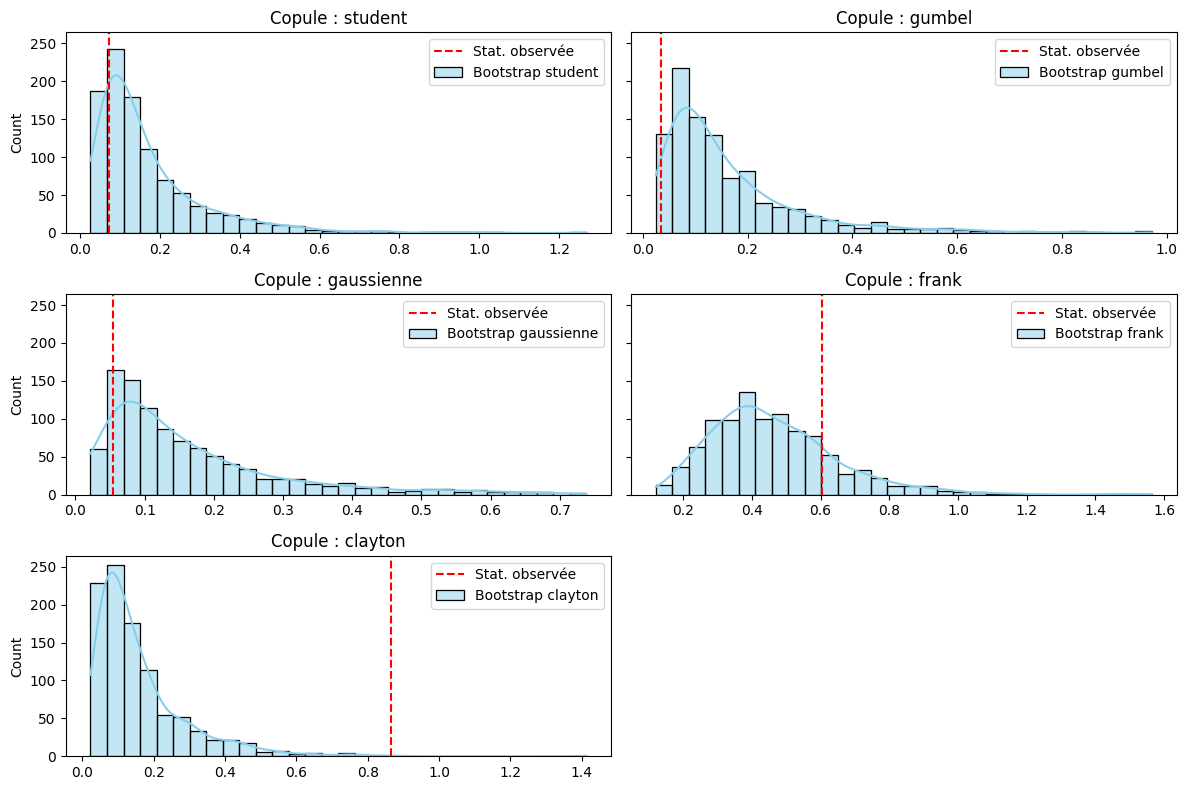

In [ ]:
# === Tracer les distributions bootstrap ===
# Création des subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()  # Transformer la matrice d'axes en liste 1D

for (name, res), ax in zip(bootstrap_results.items(), axes):
    boot_vals = res["boot"]
    obs_val = res["obs"]

    sns.histplot(boot_vals, ax=ax, bins=30, kde=True, color="skyblue", label=f"Bootstrap {name}")
    ax.axvline(obs_val, color='r', linestyle='--', label="Stat. observée")
    ax.set_title(f"Copule : {name}")
    ax.legend()

# Supprimer les axes vides si nécessaire
for i in range(len(bootstrap_results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Déterminer la CreditVaR à 99% du portefeuille en utilisant la méthode de Monte Carlo.

# Calcul de la CreditVar à 99% avec simulation de Monte Carlo

---
Objectif: Estimer la perte potentielle maximale du portefeuille à un niveau de confiance de 99%.

Ayant modéliser la structure de dépendance entre les facteurs de risques, il est désormais possible de modéliser la distribution jointe des temps défaut $(\tau_{BNP}, \tau_{SG})$, et par conséquent simuler des réalisations des pertes sur le portefeuille.

- Nous simulons 1000 échantillons de 100_000 réalisation de pertes, et pour chaque échantillon nous estimons la CVaR à 99%. Ceci nous permet alors d'obtenir une estimation de la CVaR à 99% avec un intervalle de confiance.
- En faisant varier le nombre de réalisation de pertes entre 1000 et 30_000, on évaluera la convergence de notre estimation de la CVaR.

In [44]:
from copulae import pseudo_obs
from copulae.archimedean import ClaytonCopula, GumbelCopula, FrankCopula

# Caractérisation des taux de recoubvrement
def recovery_rate(mu, sigma, size=10_000):
    a = mu*(mu*(1-mu)/sigma**2 - 1)
    b =(1- mu)*(mu*(1-mu)/sigma**2 - 1)
    return  np.random.beta(a,b, size=size)
    


In [64]:
# Evaluer la convergence de la CVaR
M = 10_000
B = 1000

# Spread de maturité 4 ans
spread_bnp = 0.01
spread_sg = 0.012
EAD_bnp = 1000
EAD_sg = 1000

# Fixer une graine pour la reproductibilité

np.random.seed(42)
# Structure de dépendance

# Obtain Transformed (pseudo observations) sample
var_bnp = pseudo_obs(data_returns["BNP"])
var_sg = pseudo_obs(data_returns["SG"])
data = pd.DataFrame([var_bnp, var_sg]).T
data.columns = ["var_bnp", "var_sg"]

# Estimation de la structure de dépendance
structure_dependance = GumbelCopula()
structure_dependance.fit(data)

# Probabilité de défaut 
PD_bnp = pd_from_cds(spread_bp=100, maturity=4)
PD_sg = pd_from_cds(spread_bp=120, maturity=4)


def  calcul_CVaR(M,B):
    CVar = np.zeros(B)
    for t in range(B):
        # Recouvrement
        recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15, size=M)
        recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25, size=M) 

        # Evènements de défaut
        u = structure_dependance.random(M)
        default_bnp = (u.var_bnp <= PD_bnp).astype(int)
        default_sg = (u.var_sg <= PD_sg).astype(int)

        # Loss function
        L = EAD_bnp*(1-recovery_bnp)*default_bnp + EAD_sg*(1-recovery_sg)*default_sg
        CVar[t] = np.quantile(L, 0.99)
    return CVar

          var_bnp      var_sg
count  999.000000  999.000000
mean     0.500000    0.500000
std      0.288527    0.288528
min      0.001000    0.001000
25%      0.250500    0.250500
50%      0.500000    0.500000
75%      0.749500    0.749500
max      0.999000    0.999000


In [65]:
np.random.seed(42)

CVar = np.zeros(B)
for t in range(B):
    # Recouvrement
    recovery_bnp = recovery_rate(mu = 0.6, sigma = 0.15, size=M)
    recovery_sg = recovery_rate(mu = 0.3, sigma = 0.25, size=M) 

    # Evènements de défaut
    u = structure_dependance.random(M)
    default_bnp = (u.var_bnp <= PD_bnp).astype(int)
    default_sg = (u.var_sg <= PD_sg).astype(int)

    # Loss function
    L = EAD_bnp*(1-recovery_bnp)*default_bnp + EAD_sg*(1-recovery_sg)*default_sg
    CVar[t] = np.quantile(L, 0.99)

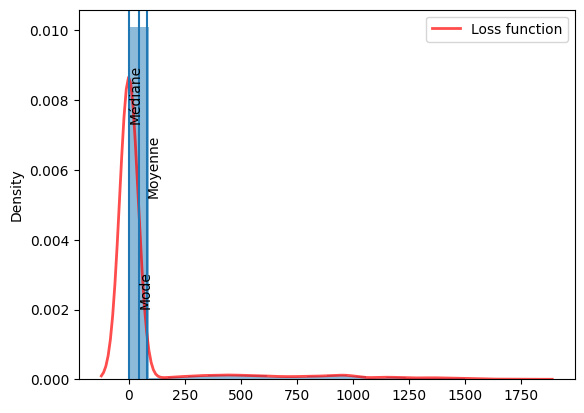

In [66]:
# Simulation de 10_000 scénarios de pertes
HistogPlot(L, label="Loss function")

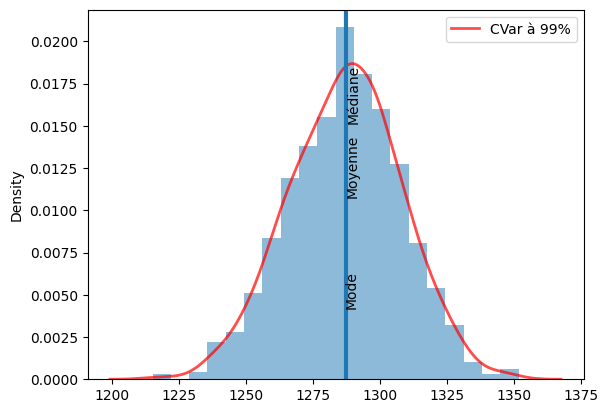

In [67]:
# Estimation d'une CVaR à 99%
HistogPlot(CVar, label="CVar à 99%")

In [68]:
# CVAR
print("CVaR à 99%:\t", round(CVar.mean(),2))
print("IC à 95% de la CVaR à 99% :\t [", round(np.quantile(CVar, 1 - 0.975),2),
                                       round(np.quantile(CVar, 0.975),2),
                                       "]")


CVaR à 99%:	 1287.03
IC à 95% de la CVaR à 99% :	 [ 1245.81 1327.01 ]


Convergence de l'estimateur de la CVaR

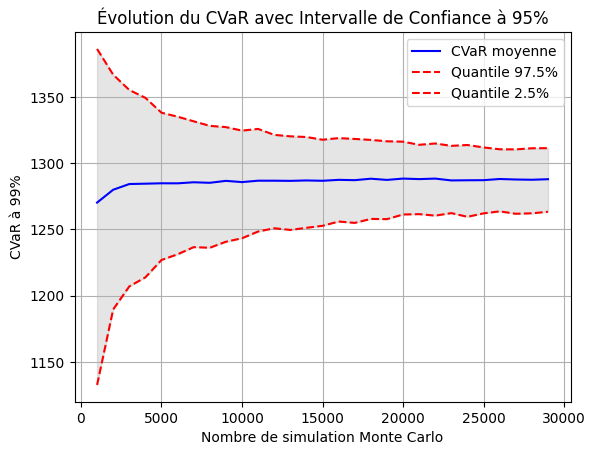

In [ ]:
# Convergence de l'estimateur

np.random.seed(42)

M = np.arange(1000, 30_000, 1000)
CVaR = np.array([calcul_CVaR(m,B) for m in M])

plt.plot(M, np.mean(CVaR, axis=1), label="CVaR moyenne", color='blue')
plt.plot(M, np.quantile(CVaR, 0.975, axis=1), label="Quantile 97.5%", linestyle="dashed", color='red')
plt.plot(M, np.quantile(CVaR, 0.025, axis=1), label="Quantile 2.5%", linestyle="dashed", color='red')

plt.fill_between(M, np.quantile(CVaR, 0.025, axis=1), np.quantile(CVaR, 0.975, axis=1), color='gray', alpha=0.2)

plt.xlabel("Nombre de simulation Monte Carlo")
plt.ylabel("CVaR à 99%")
plt.legend()
plt.title("Évolution du CVaR avec Intervalle de Confiance à 95%")
plt.grid(True)
plt.show()
